In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [210]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

n = 15
m = 85

kw = {
    'seed': 125396749,
    'speeds': [105],
    'chargers': list(range(1, 16)),
    'scale': (1e6, 1e6),
    'graph': {
        'directed': True,
    },
}

graph = src.rng.random_completely_connected_graph(
    n, m, **kw,
)

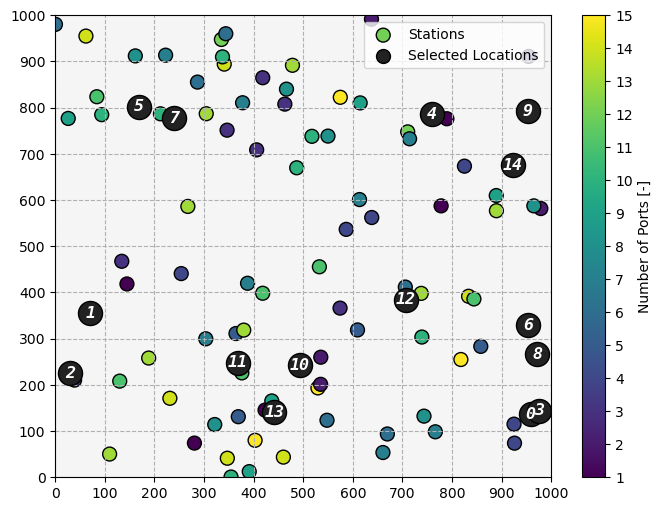

In [211]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [n for n in graph.nodes if 'destination' in n]
stations = [n for n in graph.nodes if 'station' in n]

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 100,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        'ticks': list(range(1, 16)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#222222',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(destinations, ax = ax, **kw)

x = [n['x'] for n in destinations._node.values()]
y = [n['y'] for n in destinations._node.values()]
n = [f'{n}' for n in range(destinations.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontweight': 'bold',
    'fontfamily': 'monospace',
    'color': '#ffffff'
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

In [212]:
deep_reload(src)

vehicle_kw = {
    'cases': 30,
    'risk_attitude': (0, 1),
}

vehicle = src.routing.Vehicle(**vehicle_kw)
vehicle.linear_fraction = .8

ac_power = 6.6e3
dc_power = 80e3
capacity = 80 * 3.6e6

print(vehicle.ac_charge(0, .8, ac_power, capacity) / 3600)

print(vehicle.dc_charge(0, .8, dc_power, capacity) / 3600)

print(vehicle.ac_charge(0, .99, ac_power, capacity) / 3600)

print(vehicle.dc_charge(0, .99, dc_power, capacity) / 3600)

9.696969696969697
0.8
12.0
1.399146454710798


In [292]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
# seed = None
rng = np.random.default_rng(seed)

risk_attitude = (0, .2)
risk_attitude = (.8, 1)
rho = np.linspace(*risk_attitude, 100)

cases = 30

station_kw = {}

station_kw['destination'] = {
    'cases': 1,
    'type': 'ac',
    'access': 'private',
    'price': .4 / 3.6e6,
    'setup_time': 0,
    'rng': rng,
}

station_kw['station'] = {
    'reliability': .5,
    'cases': cases,
    'type': 'dc',
    'access': 'public',
    'power': 120e3,
    'price': .5 / 3.6e6,
    'setup_time': 300,
    'rng': rng,
}

vehicle_kw = {
    'cases': 1,
    'linear_fraction': .8,
    'risk_attitude': (0, 1),
}

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

In [301]:
deep_reload(src)

destinations = [k for k, v in graph._node.items() if v['type'] == 'destination']
origins = ['destination_0']

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, origins, objective = vehicle, destinations = destinations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0281 seconds


In [302]:
deep_reload(src)

origins = [k for k, v in graph._node.items() if v['type'] == 'destination']

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    graph, origins, objective = vehicle,
)

print(f'\n\nExecuted in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 35.61 it/s, 0.45 s elapsed, 0.00 s remaining

Executed in 0.4499 seconds


In [303]:
src.routing.impedance(values, field = 'total_time') / 3600

1.850408412110779

In [166]:
paths

{'destination_0': ['destination_0'],
 'destination_1': ['destination_0', 'station_48', 'destination_1'],
 'destination_2': ['destination_0', 'station_48', 'destination_2'],
 'destination_3': ['destination_0', 'destination_3'],
 'destination_4': ['destination_0', 'station_17', 'destination_4'],
 'destination_5': ['destination_0',
  'station_1',
  'station_37',
  'destination_5'],
 'destination_6': ['destination_0', 'destination_6'],
 'destination_7': ['destination_0',
  'station_82',
  'station_15',
  'destination_7'],
 'destination_8': ['destination_0', 'destination_8'],
 'destination_9': ['destination_0', 'station_23', 'destination_9'],
 'destination_10': ['destination_0', 'destination_10'],
 'destination_11': ['destination_0', 'station_69', 'destination_11'],
 'destination_12': ['destination_0', 'destination_12'],
 'destination_13': ['destination_0', 'destination_13'],
 'destination_14': ['destination_0', 'station_46', 'destination_14']}

In [162]:
paths

{'destination_0': ['destination_0'],
 'destination_1': ['destination_0', 'station_42', 'destination_1'],
 'destination_2': ['destination_0', 'station_48', 'destination_2'],
 'destination_3': ['destination_0', 'destination_3'],
 'destination_4': ['destination_0', 'station_46', 'destination_4'],
 'destination_5': ['destination_0',
  'station_64',
  'station_15',
  'destination_5'],
 'destination_6': ['destination_0', 'destination_6'],
 'destination_7': ['destination_0',
  'station_64',
  'station_15',
  'destination_7'],
 'destination_8': ['destination_0', 'destination_8'],
 'destination_9': ['destination_0', 'station_46', 'destination_9'],
 'destination_10': ['destination_0', 'destination_10'],
 'destination_11': ['destination_0', 'station_69', 'destination_11'],
 'destination_12': ['destination_0', 'destination_12'],
 'destination_13': ['destination_0', 'destination_13'],
 'destination_14': ['destination_0', 'station_64', 'destination_14']}